<a href="https://colab.research.google.com/github/ShuoWang111/6105data/blob/main/MoreHomework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# More Homework

**Xuliang Mei**

**Shuo Wang**

## Dependencies

In [ ]:
!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4
!pip install dcor

In [ ]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import pymc3 as pm
import dcor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

## Data Pre-process

The data comes from [Rain in Australia by Kaggle](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package). For simplification I will drop some clomnus which are hard to process and focus only on Sidney. This data is not artificial so we don't need to add noises.

In [ ]:
data = pd.read_csv('./weatherAUS.csv', error_bad_lines=False)

b'Skipping line 86806: expected 23 fields, saw 24\n'
b'Skipping line 108733: expected 23 fields, saw 33\n'
b'Skipping line 194850: expected 23 fields, saw 31\n'
b'Skipping line 216184: expected 23 fields, saw 31\n'
b'Skipping line 237830: expected 23 fields, saw 26\n'
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3,5,6,8,12,13,14,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# select only Sydney
df = data[data['Location'] == 'Sydney']
# drop some cols
df = df.drop(columns=['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'Location', 'RainTomorrow'])
# set index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
# map yes/no to 1/0
# df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})
# change object to float
for column in df:
  df[column] = pd.to_numeric(df[column],errors='coerce')
# drop NA values
df = df.dropna()

# peek data
df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
Date,,,,,,,,,,,,,,,,
2010-10-20,12.90,20.30,0.20,3.00,10.90,37.00,11.00,26.00,70.00,57.00,"1,028.80","1,025.60",3.00,1.00,16.90,19.80
2010-10-21,13.30,21.50,0.00,6.60,11.00,41.00,11.00,28.00,75.00,58.00,"1,025.90","1,022.40",2.00,5.00,17.60,21.30
2010-10-22,15.30,23.00,0.00,5.60,11.00,41.00,6.00,19.00,70.00,63.00,"1,021.40","1,017.80",1.00,4.00,19.00,22.20
2010-10-26,12.90,26.70,0.20,3.80,12.10,33.00,13.00,24.00,73.00,56.00,"1,018.00","1,015.00",1.00,5.00,17.80,22.50
2010-10-27,14.80,23.80,0.00,6.80,9.60,54.00,13.00,26.00,76.00,69.00,"1,016.00","1,014.70",2.00,7.00,20.20,20.60


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3397 entries, 2010-10-20 to 2017-06-25
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        3397 non-null   float64
 1   MaxTemp        3397 non-null   float64
 2   Rainfall       3397 non-null   float64
 3   Evaporation    3397 non-null   float64
 4   Sunshine       3397 non-null   float64
 5   WindGustSpeed  3397 non-null   float64
 6   WindSpeed9am   3397 non-null   float64
 7   WindSpeed3pm   3397 non-null   float64
 8   Humidity9am    3397 non-null   float64
 9   Humidity3pm    3397 non-null   float64
 10  Pressure9am    3397 non-null   float64
 11  Pressure3pm    3397 non-null   float64
 12  Cloud9am       3397 non-null   float64
 13  Cloud3pm       3397 non-null   float64
 14  Temp9am        3397 non-null   float64
 15  Temp3pm        3397 non-null   float64
dtypes: float64(16)
memory usage: 451.2 KB


## Variables Choose

In this section I'm gonna plot the correlation matrix and table to see relationship between all the columns. Here the dependent column will be **Rainfall**

In [ ]:
# helper funcs
def dist_corr(X, Y, pval=True, nruns=2000):
    """ Distance correlation with p-value from bootstrapping
    """
    dc = dcor.distance_correlation(X, Y)
    pv = dcor.independence.distance_covariance_test(X, Y, exponent=1.0, num_resamples=nruns)[0]
    if pval:
        return (dc, pv)
    else:
        return dc

def corrfunc(x, y, **kws):
    d, p = dist_corr(x,y) 
    #print("{:.4f}".format(d), "{:.4f}".format(p))
    if p > 0.1:
        pclr = 'Darkgray'
    else:
        pclr= 'Darkblue'
    ax = plt.gca()
    ax.annotate("DC = {:.2f}".format(d), xy=(.1, 0.99), xycoords=ax.transAxes, color = pclr, fontsize = 14)

In [ ]:
# plot
# g = sns.PairGrid(df, diag_sharey=False)
# axes = g.axes
# g.map_upper(plt.scatter, linewidths=1, edgecolor="w", s=90, alpha = 0.5)
# g.map_upper(corrfunc)
# g.map_diag(sns.kdeplot, lw = 4, legend=False)
# g.map_lower(sns.kdeplot, cmap="Blues_d")
# plt.show();

In [ ]:
# Create the distance method using distance_correlation
distcorr = lambda column1, column2: dcor.distance_correlation(column1, column2) 

# Apply the distance method pairwise to every column
rslt = df.apply(lambda col1: df.apply(lambda col2: distcorr(col1, col2)))

# check output
pd.options.display.float_format = '{:,.2f}'.format
rslt

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
MinTemp,1.00,0.76,0.08,0.56,0.14,0.19,0.33,0.24,0.13,0.32,0.40,0.36,0.25,0.17,0.92,0.74
MaxTemp,0.76,1.00,0.15,0.50,0.30,0.14,0.36,0.19,0.20,0.17,0.40,0.42,0.09,0.10,0.85,0.95
Rainfall,0.08,0.15,1.00,0.17,0.34,0.11,0.11,0.04,0.39,0.31,0.04,0.06,0.30,0.23,0.10,0.15
Evaporation,0.56,0.50,0.17,1.00,0.21,0.31,0.17,0.33,0.38,0.12,0.35,0.31,0.05,0.06,0.60,0.48
Sunshine,0.14,0.30,0.34,0.21,1.00,0.07,0.06,0.22,0.50,0.55,0.08,0.11,0.70,0.72,0.16,0.31
WindGustSpeed,0.19,0.14,0.11,0.31,0.07,1.00,0.27,0.56,0.29,0.18,0.47,0.40,0.03,0.06,0.21,0.12
WindSpeed9am,0.33,0.36,0.11,0.17,0.06,0.27,1.00,0.16,0.19,0.21,0.13,0.17,0.09,0.06,0.37,0.37
WindSpeed3pm,0.24,0.19,0.04,0.33,0.22,0.56,0.16,1.00,0.29,0.14,0.30,0.25,0.07,0.13,0.30,0.18
Humidity9am,0.13,0.20,0.39,0.38,0.50,0.29,0.19,0.29,1.00,0.61,0.26,0.26,0.43,0.34,0.17,0.18
Humidity3pm,0.32,0.17,0.31,0.12,0.55,0.18,0.21,0.14,0.61,1.00,0.17,0.19,0.43,0.49,0.23,0.20


Seen from above table, for the rainfall column, we found that these independent columns has stronger DC than other columns:


1.   **Sunshine**
2.   **Humidity9am**
3.   **Humidity3pm**
4.   **Cloud9am**
5.   **Cloud3pm**

Thus we will choose these few columns to predict the Rainfall column.


## Random Forest-Based

### Partial Columns

In [ ]:
cols_need = ['Sunshine', 'Humidity9am', 'Humidity3pm', 'Cloud9am', 'Cloud3pm']
X = df[cols_need]
y = df['Rainfall']
X, y

(            Sunshine  Humidity9am  Humidity3pm  Cloud9am  Cloud3pm
 Date                                                              
 2010-10-20     10.90        70.00        57.00      3.00      1.00
 2010-10-21     11.00        75.00        58.00      2.00      5.00
 2010-10-22     11.00        70.00        63.00      1.00      4.00
 2010-10-26     12.10        73.00        56.00      1.00      5.00
 2010-10-27      9.60        76.00        69.00      2.00      7.00
 ...              ...          ...          ...       ...       ...
 2017-06-21      7.80        73.00        52.00      2.00      2.00
 2017-06-22      9.20        78.00        53.00      2.00      2.00
 2017-06-23      2.70        85.00        56.00      6.00      6.00
 2017-06-24      9.30        56.00        35.00      5.00      2.00
 2017-06-25      9.40        73.00        32.00      1.00      1.00
 
 [3397 rows x 5 columns], Date
 2010-10-20   0.20
 2010-10-21   0.00
 2010-10-22   0.00
 2010-10-26   0.20
 2010-1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Create a model 
rf_model = RandomForestRegressor(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
# Get R2 measure (indicator of accuracy 1 is perfect, 0 is horrible)
rf_model.score(X_test, y_test)

0.6060780548161688

### All Possible Columns

In [ ]:
X = df.drop(columns=['Rainfall'])
y = df['Rainfall']
X, y

(            MinTemp  MaxTemp  Evaporation  ...  Cloud3pm  Temp9am  Temp3pm
 Date                                       ...                            
 2010-10-20    12.90    20.30         3.00  ...      1.00    16.90    19.80
 2010-10-21    13.30    21.50         6.60  ...      5.00    17.60    21.30
 2010-10-22    15.30    23.00         5.60  ...      4.00    19.00    22.20
 2010-10-26    12.90    26.70         3.80  ...      5.00    17.80    22.50
 2010-10-27    14.80    23.80         6.80  ...      7.00    20.20    20.60
 ...             ...      ...          ...  ...       ...      ...      ...
 2017-06-21     8.60    19.60         2.00  ...      2.00    10.50    17.90
 2017-06-22     9.30    19.20         2.00  ...      2.00    11.00    18.70
 2017-06-23     9.40    17.70         2.40  ...      6.00    10.20    17.30
 2017-06-24    10.10    19.30         1.40  ...      2.00    12.40    19.00
 2017-06-25     7.60    19.30         3.40  ...      1.00     9.40    18.80
 
 [3397 row

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Create a model 
rf_model = RandomForestRegressor(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
# Get R2 measure (indicator of accuracy 1 is perfect, 0 is horrible)
rf_model.score(X_test, y_test)

0.6352270237612121

Seen from above, at the same random seed, the all-possible-columns-prediction is slightly better.

## Bayesian Regression Estimation

For Bayesian regression, we will only use the few strong independent columns to predict the rainfall.

In [ ]:
with pm.Model() as glm_model:
    pm.glm.GLM.from_formula('Rainfall ~ Sunshine + Humidity9am + Humidity3pm + Cloud9am + Cloud3pm',
                            df,
                            family=pm.glm.families.Normal())
    trace2 = pm.sample(1000, tune=1000, init='adapt_diag', cores=1)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (2 chains in 1 job)
INFO:pymc3:Sequential sampling (2 chains in 1 job)
NUTS: [sd, Cloud3pm, Cloud9am, Humidity3pm, Humidity9am, Sunshine, Intercept]
INFO:pymc3:NUTS: [sd, Cloud3pm, Cloud9am, Humidity3pm, Humidity9am, Sunshine, Intercept]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:34<00:00, 58.40it/s]


/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f674a4df9d0>,
      dtype=object)

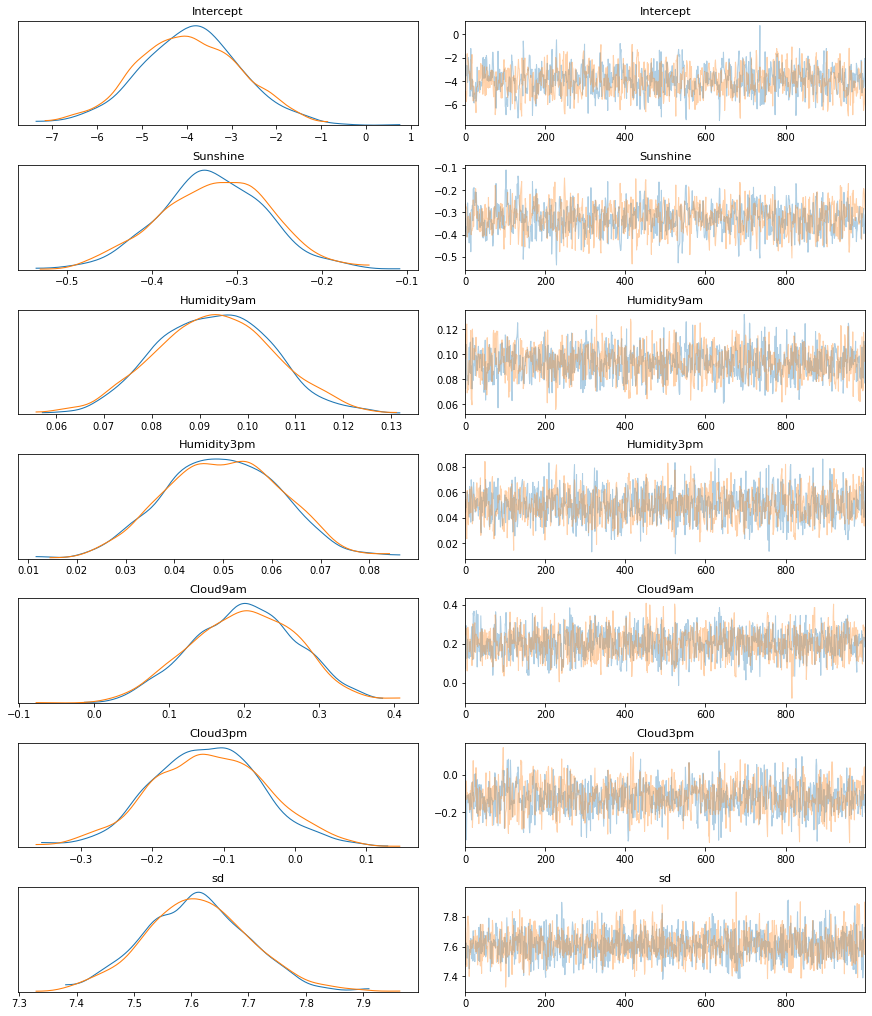

In [ ]:
pm.traceplot(trace2)

/usr/local/lib/python3.7/dist-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f674927a050>,
      dtype=object)

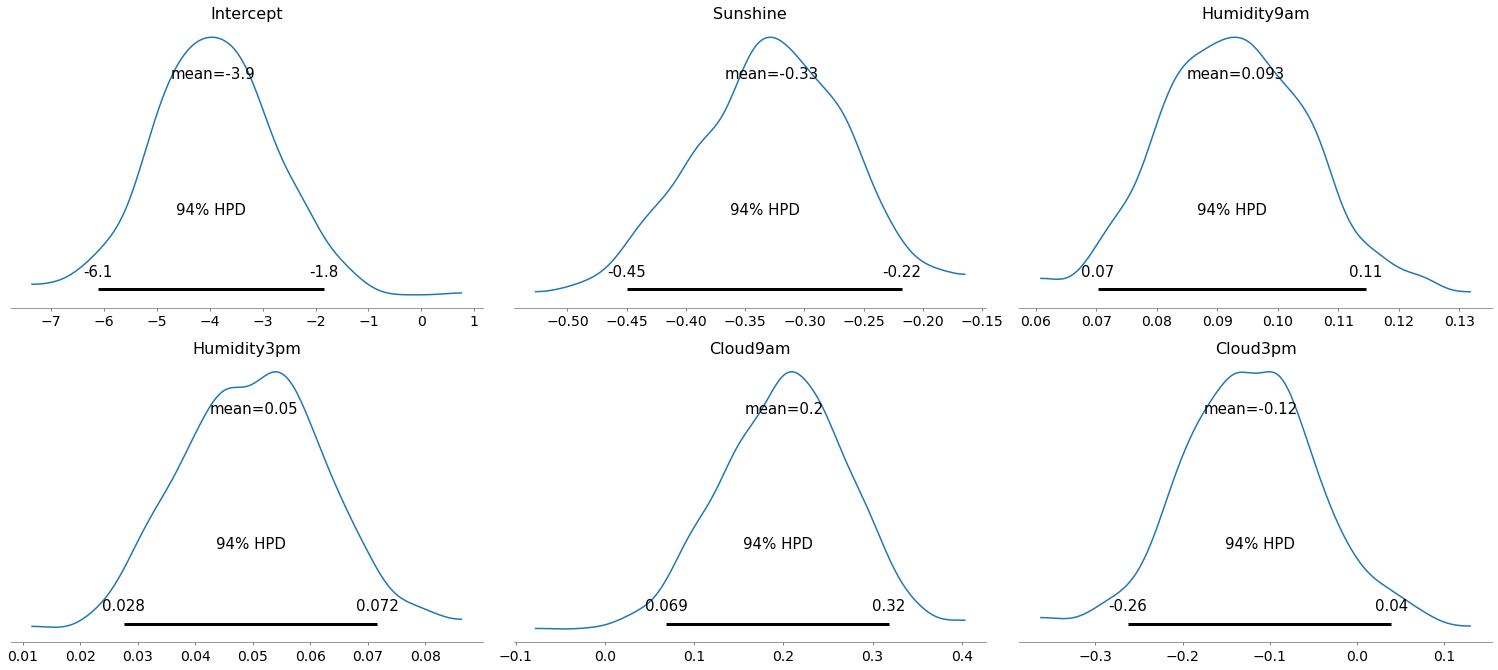

In [ ]:
pm.plot_posterior(trace2[500:], varnames=['Intercept', 'Sunshine', 'Humidity9am', 'Humidity3pm', 'Cloud9am', 'Cloud3pm'])